# Lift Calculations Python script

Author - Rahul Singla<br>

Co-authors - Anant Gupta, Ishan Patel, Vinay Pahwa, Suchit Das

Created on Google Colab

# Data Cleanup and Zipf's Law

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import regex as re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import nltk
nltk.download('stopwords')
from sklearn.manifold import MDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
complete_data = pd.read_csv("/content/gdrive/MyDrive/unstructured assignment 1/data1.csv")
df = complete_data.copy().iloc[-5000:].reset_index(drop = True)
df.head()

,Unnamed: 0,Date,user_id,comments
0,16733,"March 18, 2014 6:48PM",sweendogy,Wow these message boards are dormant -
1,16734,"March 18, 2014 8:03PM",Michaell,We're all out driving or test-driving.
2,16735,"March 23, 2014 6:47PM",sweendogy,I guess or format still not taking hold-\n\nFo...
3,16736,"March 23, 2014 6:47PM",sweendogy,Pix
4,16737,"March 23, 2014 8:16PM",nyccarguy,@sweendogy\nI see you hate your state's front ...


In [ ]:
thread_count = len(df)

In [ ]:
def clean_text(string):
    if pd.isna(string):
        return ""
    string = string.lower()
    string = string.replace("\n", " ").replace("\t", " ")
    string = text_after = re.sub(r'[^\w]', ' ', string)
    return string

In [ ]:
corpus = ""
n = len(df)

for i in range(n):
    corpus = corpus + clean_text(df["comments"].iloc[i])

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([corpus])
word_count = pd.Series(X.toarray()[0], index=vectorizer.get_feature_names())

In [ ]:
ranked_word_count = word_count.sort_values(ascending=False).reset_index().reset_index()
ranked_word_count.columns = ['rank', 'word', 'freq']
ranked_word_count['rank'] = ranked_word_count['rank'] + 1
ranked_word_count = ranked_word_count.copy().iloc[:100]
ranked_word_count

,rank,word,freq
0,1,the,24002
1,2,to,10033
2,3,and,9876
3,4,of,7369
4,5,it,6684
...,...,...,...
95,96,those,601
96,97,price,599
97,98,same,593
98,99,go,584


In [ ]:
ranked_word_count['rank_log'] = np.log10(ranked_word_count['rank'])
ranked_word_count['freq_log'] = np.log10(ranked_word_count['freq'])
ranked_word_count['dummy'] = 0 #dummy col added for sklearn

In [ ]:
lr = LinearRegression()
lr.fit(ranked_word_count[['rank_log', 'dummy']], ranked_word_count['freq_log'])
lr.score(ranked_word_count[['rank_log', 'dummy']], 
         ranked_word_count['freq_log'])

0.987781733076035

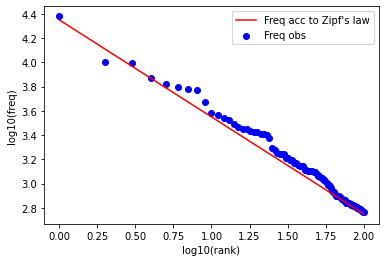

In [ ]:
plt.scatter(ranked_word_count['rank_log'],
            ranked_word_count['freq_log'],
            color = 'blue',
            label = "Freq obs")
plt.plot([0, 2],[4.35, 2.75], color = "red", label = "Freq acc to Zipf's law")
plt.xlabel("log10(rank)")
plt.ylabel("log10(freq)")
plt.legend()
plt.show()

# Finding most popular car models

In [ ]:

# please note the csv was modified. Some 30 odd entries were added for better cleaning
car_models = pd.read_csv('/content/gdrive/MyDrive/unstructured assignment 1/car models and brands.csv')
car_models

,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx
...,...,...
555,honda,s2000
556,toyota,extoyota
557,acura,tls
558,bmw,550i


In [ ]:
#let's replace models with brand so that we can have better understanding of brand popularity
for brand, model in zip(car_models['Brand'], car_models['Model']):
  corpus = corpus.replace(model, brand)

In [ ]:
vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'),)
X = vectorizer.fit_transform([corpus])
word_count = pd.Series(X.toarray()[0], index=vectorizer.get_feature_names())
ranked_word_count = word_count.sort_values(ascending=False).reset_index().reset_index()
ranked_word_count.columns = ['rank', 'word', 'freq']
ranked_word_count['rank'] = ranked_word_count['rank'] + 1
ranked_word_count.to_csv('/content/gdrive/MyDrive/unstructured assignment 1/word_freq.csv')

Top 10 car models - BMW, Accura, Audi, Toyota, Honda, Subrau, Volkswagen, Chrysler, Cadillac, Hyundai 

# Lift Calculations

In [ ]:
def clean_text_brands(string):
    if pd.isna(string):
        return ""
    string = string.lower()
    string = string.replace("\n", " ").replace("\t", " ")
    string = text_after = re.sub(r'[^\w]', ' ', string)
    for brand, model in zip(car_models['Brand'], car_models['Model']):
      string = string.replace(model, brand)

    return string

df['cleaned_comments'] = df['comments'].apply(clean_text_brands)

In [ ]:
mentions = pd.DataFrame()

top_brands = ['bmw', 'acura', 'audi', 'toyota', 'honda', 'chrysler', 
              'subaru', 'volkswagen', 'cadillac', 'hyundai']

for brand in top_brands:
  mentions[brand] = df['cleaned_comments'].apply(lambda s: 1 if brand in s else 0)

In [ ]:
total_mentions = mentions.sum()
total_mentions

bmw           1114
acura         1350
audi          1170
toyota        1187
honda          602
chrysler       418
subaru        1288
volkswagen     277
cadillac       227
hyundai        206
dtype: int64

In [ ]:
co_mentions = pd.DataFrame(index = top_brands, columns=top_brands)

for brand1 in top_brands:
  for brand2 in top_brands:
    co_mentions[brand1][brand2] = pd.crosstab(mentions[brand1], mentions[brand2])[1][1]
co_mentions

,bmw,acura,audi,toyota,honda,chrysler,subaru,volkswagen,cadillac,hyundai
bmw,1114,428,426,394,197,102,415,76,99,67
acura,428,1350,540,558,352,284,555,113,116,87
audi,426,540,1170,470,250,151,484,141,118,72
toyota,394,558,470,1187,279,146,481,111,108,85
honda,197,352,250,279,602,144,277,62,49,53
chrysler,102,284,151,146,144,418,167,22,43,27
subaru,415,555,484,481,277,167,1288,111,92,94
volkswagen,76,113,141,111,62,22,111,277,17,22
cadillac,99,116,118,108,49,43,92,17,227,20
hyundai,67,87,72,85,53,27,94,22,20,206


In [ ]:
joint_support = co_mentions / thread_count
joint_support

,bmw,acura,audi,toyota,honda,chrysler,subaru,volkswagen,cadillac,hyundai
bmw,0.2228,0.0856,0.0852,0.0788,0.0394,0.0204,0.083,0.0152,0.0198,0.0134
acura,0.0856,0.27,0.108,0.1116,0.0704,0.0568,0.111,0.0226,0.0232,0.0174
audi,0.0852,0.108,0.234,0.094,0.05,0.0302,0.0968,0.0282,0.0236,0.0144
toyota,0.0788,0.1116,0.094,0.2374,0.0558,0.0292,0.0962,0.0222,0.0216,0.017
honda,0.0394,0.0704,0.05,0.0558,0.1204,0.0288,0.0554,0.0124,0.0098,0.0106
chrysler,0.0204,0.0568,0.0302,0.0292,0.0288,0.0836,0.0334,0.0044,0.0086,0.0054
subaru,0.083,0.111,0.0968,0.0962,0.0554,0.0334,0.2576,0.0222,0.0184,0.0188
volkswagen,0.0152,0.0226,0.0282,0.0222,0.0124,0.0044,0.0222,0.0554,0.0034,0.0044
cadillac,0.0198,0.0232,0.0236,0.0216,0.0098,0.0086,0.0184,0.0034,0.0454,0.004
hyundai,0.0134,0.0174,0.0144,0.017,0.0106,0.0054,0.0188,0.0044,0.004,0.0412


In [ ]:
support = total_mentions / thread_count
support

bmw           0.2228
acura         0.2700
audi          0.2340
toyota        0.2374
honda         0.1204
chrysler      0.0836
subaru        0.2576
volkswagen    0.0554
cadillac      0.0454
hyundai       0.0412
dtype: float64

In [ ]:
lift = pd.DataFrame(index = top_brands, columns=top_brands)

for brand1 in top_brands:
  for brand2 in top_brands:
    if brand1 == brand2:
      lift[brand1][brand2] = np.nan
      continue
    lift[brand1][brand2] = joint_support[brand1][brand2] / (support[brand1] * support[brand2])
lift_new = np.triu(lift)
lift_df = pd.DataFrame(lift_new,columns=top_brands,index=top_brands)
lift_df = lift_df.fillna(0)
lift_df = lift_df.replace(0,"")
lift_df

,bmw,acura,audi,toyota,honda,chrysler,subaru,volkswagen,cadillac,hyundai
bmw,,1.42297,1.63421,1.48981,1.46877,1.09524,1.44616,1.23146,1.95747,1.4598
acura,,,1.7094,1.74108,2.16562,2.51639,1.59593,1.5109,1.89264,1.56419
audi,,,,1.69212,1.77471,1.54378,1.60588,2.17532,2.22147,1.49365
toyota,,,,,1.95221,1.47128,1.57307,1.68796,2.00409,1.73808
honda,,,,,,2.86128,1.78623,1.85903,1.79285,2.13689
chrysler,,,,,,,1.55094,0.950029,2.26588,1.5678
subaru,,,,,,,,1.5556,1.57332,1.77139
volkswagen,,,,,,,,,1.3518,1.92773
cadillac,,,,,,,,,,2.13849
hyundai,,,,,,,,,,


# MDS Graph - visualizing closeness among brands

In [ ]:
dissimilarity = pd.DataFrame(index = top_brands, columns=top_brands)

for brand1 in top_brands:
  for brand2 in top_brands:
    if brand1 == brand2:
      dissimilarity[brand1][brand2] = np.nan
      continue
    dissimilarity[brand1][brand2] = 1/ (lift[brand1][brand2])
dissimilarity_new = np.triu(dissimilarity)
dissimilarity_df = pd.DataFrame(dissimilarity_new,columns=top_brands,index=top_brands)
dissimilarity_df = dissimilarity_df.replace(0,"")
dissimilarity_df = dissimilarity_df.fillna(0)
dissimilarity_df

,bmw,acura,audi,toyota,honda,chrysler,subaru,volkswagen,cadillac,hyundai
bmw,0,0.702757,0.611915,0.671227,0.680841,0.913043,0.691485,0.812047,0.510865,0.685027
acura,,0,0.585,0.574355,0.461761,0.397394,0.626595,0.661858,0.528362,0.639310
audi,,,0,0.590974,0.563472,0.647762,0.622711,0.459702,0.450153,0.669500
toyota,,,,0,0.512239,0.679679,0.635699,0.592431,0.49898,0.575346
honda,,,,,0,0.349494,0.559838,0.537916,0.557771,0.467970
chrysler,,,,,,0,0.644771,1.0526,0.44133,0.637837
subaru,,,,,,,0,0.64284,0.6356,0.564528
volkswagen,,,,,,,,0,0.739753,0.518745
cadillac,,,,,,,,,0,0.467620
hyundai,,,,,,,,,,0.000000


In [ ]:
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(dissimilarity.fillna(0))
X_2d

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


array([[-0.88239255,  0.08215014],
       [ 0.42938507,  0.305424  ],
       [-0.39857842, -0.12233817],
       [ 0.34842248, -0.47276098],
       [ 0.55803723, -0.06872726],
       [ 0.62958109,  0.65438566],
       [-0.33384195,  0.55292828],
       [-0.35076191, -0.82957088],
       [-0.01279559,  0.27699506],
       [ 0.01294453, -0.37848587]])

No handles with labels found to put in legend.


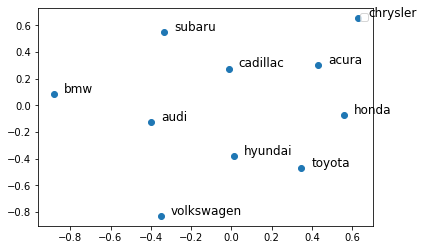

In [ ]:
plt.scatter(X_2d[:,0], X_2d[:,1])
i=0

for brand in top_brands:
  plt.text(X_2d[i,0] + 0.05, 
           X_2d[i,1] + 0.01, 
           brand, fontsize = 12)
  i += 1
plt.legend()
plt.show()

# Insights

Based on lift values and MDS plot, we can see that when people talk about Honda brand, then they talk about Acura and Toyota too. This could imply that customers often compare cars of these brands. A point to note is that all these 3 brands are Japanese. So, it makes logical sense that people might be comparing Japanese cars. It could also imply that people are open to switching among Japanese brands. To get more concrete and actionable insights, more data should be obtained on actual brand switching.

Another interesting point to note is that Audi and Volkswagen are both German brands but still pretty far in terms of comentions or people percieve them to be not so similar. Same thing can be found for Cadillac and Chrysler which are both under General Motors parent company.

Another point of observation is that when people talk about BMW, then they don't talk about other brands as much. This could imply that in people's mind, BMW is an outlier.  

# Finding top attributes & their relation with different brands

In [ ]:
attribute_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'),
                                       ngram_range = (1, 2))
X = attribute_vectorizer.fit_transform([corpus])
word_count = pd.Series(X.toarray()[0], index=attribute_vectorizer.get_feature_names())
ranked_count = word_count.sort_values(ascending=False).reset_index()
ranked_count.columns = ['word', 'freq']
ranked_count.to_csv('/content/gdrive/MyDrive/unstructured assignment 1/freq.csv')

Top 5 attributes 
1. Price
2. Sport 
3. Performance
4. Engine
5. Luxury

Other attributes - Power, HP, Cost, Problem, Manual, Interior

In [ ]:
top_attributes = ['performance', 'luxury', 'engine', 'sport', 'price']

attribute_mentions = pd.DataFrame()

for attr in top_attributes:
  attribute_mentions[attr] = df['cleaned_comments'].apply(lambda s: 1 if attr in s else 0)

In [ ]:
total_attribute_mentions = attribute_mentions.sum()
total_attribute_mentions

performance    312
luxury         285
engine         433
sport          496
price          573
dtype: int64

In [ ]:
attr_comentions = pd.DataFrame(index = top_brands, columns=top_attributes)

for brand in top_brands:
  for attr in top_attributes:
    attr_comentions[attr][brand] = pd.crosstab(mentions[brand], attribute_mentions[attr])[1][1]
attr_comentions

,performance,luxury,engine,sport,price
bmw,132,105,155,234,231
acura,169,144,211,225,258
audi,142,115,174,230,217
toyota,133,121,190,225,224
honda,72,73,99,131,130
chrysler,52,51,62,72,76
subaru,140,121,196,230,250
volkswagen,28,27,52,33,46
cadillac,33,44,28,31,68
hyundai,16,33,29,35,55


In [ ]:
attr_brand_support = attr_comentions / thread_count
attr_brand_support

,performance,luxury,engine,sport,price
bmw,0.0264,0.021,0.031,0.0468,0.0462
acura,0.0338,0.0288,0.0422,0.045,0.0516
audi,0.0284,0.023,0.0348,0.046,0.0434
toyota,0.0266,0.0242,0.038,0.045,0.0448
honda,0.0144,0.0146,0.0198,0.0262,0.026
chrysler,0.0104,0.0102,0.0124,0.0144,0.0152
subaru,0.028,0.0242,0.0392,0.046,0.05
volkswagen,0.0056,0.0054,0.0104,0.0066,0.0092
cadillac,0.0066,0.0088,0.0056,0.0062,0.0136
hyundai,0.0032,0.0066,0.0058,0.007,0.011


In [ ]:
attr_support = total_attribute_mentions / thread_count
attr_support

performance    0.0624
luxury         0.0570
engine         0.0866
sport          0.0992
price          0.1146
dtype: float64

In [ ]:
support

bmw           0.2228
acura         0.2700
audi          0.2340
toyota        0.2374
honda         0.1204
chrysler      0.0836
subaru        0.2576
volkswagen    0.0554
cadillac      0.0454
hyundai       0.0412
dtype: float64

In [ ]:
attr_lift = pd.DataFrame(index = top_brands, columns=top_attributes)

for brand in top_brands:
  for attr in top_attributes:
    attr_lift[attr][brand] = attr_brand_support[attr][brand] / (attr_support[attr] * support[brand])
attr_lift

,performance,luxury,engine,sport,price
bmw,1.89891,1.6536,1.60668,2.11748,1.80943
acura,2.00617,1.87135,1.80481,1.68011,1.66764
audi,1.94499,1.7244,1.7173,1.98167,1.61841
toyota,1.79563,1.78838,1.84835,1.91082,1.64669
honda,1.91669,2.12741,1.89898,2.19363,1.88435
chrysler,1.99362,2.14052,1.71276,1.73638,1.58655
subaru,1.74192,1.64814,1.7572,1.80012,1.69371
volkswagen,1.61992,1.71005,2.16773,1.20094,1.44908
cadillac,2.32972,3.40057,1.42434,1.37665,2.61396
hyundai,1.24471,2.81042,1.6256,1.71273,2.32976


# Advice

Using this table, we can understand understand what are the top things people relate to regarding a brand.

If a customer is interseted in sports car, then in addition to BMW customer can be shown an option of Honda. Normally, people don't consider for sports car. But the data suggests that Honda has similar, if not higher, association with sports than BMW.

The attribute matrix provides better understanding of why Volkswagen and Audi are not percieved to be similar. Volswagen has high lift value with Engine but Audi has high lift value with sports car. This could mean that people consider Volkswagen to be an everyday car with high quality engine, whereas, Audi is thought of as sporty car.

Looks like Cadillac has a high lift with Performance and Luxury but it has lift with price as well. This could mean that people might be willing to buy the price is too much.

# Most Aspirational Brand

Synonyms for Aspire - "Love", "Hope", "Dream", "Wish", "Desire", "Wish"

In [ ]:
synonyms = ["love", "hope", "dream", "wish", "desire", 
            "wish", "aspire"]

In [ ]:
def contains_aspiration_words(string):
  for word in synonyms:
    if word in string:
      return 1
  return 0

df['aspirational_comments'] = df['cleaned_comments'].apply(contains_aspiration_words)

In [ ]:
df['aspirational_comments'].sum()

prob_aspr = df['aspirational_comments'].sum() / thread_count

In [ ]:
aspr_comentions = pd.Series(index = top_brands, dtype='float64')

for brand in top_brands:
  aspr_comentions[brand] = pd.crosstab(mentions[brand], df['aspirational_comments'])[1][1]
aspr_comentions

bmw           181.0
acura         245.0
audi          205.0
toyota        217.0
honda         116.0
chrysler       60.0
subaru        223.0
volkswagen     48.0
cadillac       51.0
hyundai        35.0
dtype: float64

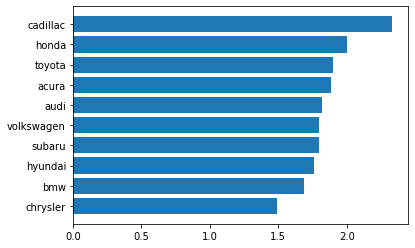

In [ ]:
lift_aspr = (aspr_comentions / thread_count) / (prob_aspr * support)
lift_aspr = lift_aspr.sort_values()
plt.barh(lift_aspr.index, lift_aspr.values)
plt.show()

# Business Implications

Clearly, Cadillac is the most aspirational brand among all the brands discussed. This could mean that people aspire to own entry level luxury cars made by Cadillac.<br>
<br>
This means people want to buy the car. The dealership should do an in-depth analysis of people don't end up buying the car. One aspect could be the high prices of the car (as shown by the attribute analysis above). The business show either try to come up with a new pricing strategy to make car more affordable or identify the customers who have the money to pay for the cars.